In [2]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda')

In [2]:
import timm

backbone = "EffV2_L"
model_map = {
    "EffV2_S": "tf_efficientnetv2_s_in21k",
    "EffV2_M": "tf_efficientnetv2_m_in21k",
    "EffV2_L": "tf_efficientnetv2_l_in21k",
    "EffV2_XL": "tf_efficientnetv2_xl_in21k",
}

model = timm.create_model(model_map[backbone], pretrained=True).to(device)
print(model)

/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_l_in21k to current tf_efficientnetv2_l.in21k.
  model = create_fn(
/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

EffV2_L
self.new_channels: 0
unit: ConvBnAct(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (drop_path): Identity()
)
unit: ConvBnAct(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (drop_path): Identity()
)
unit: ConvBnAct(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (drop_path): Identity()
)
unit: ConvBnAct(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1):

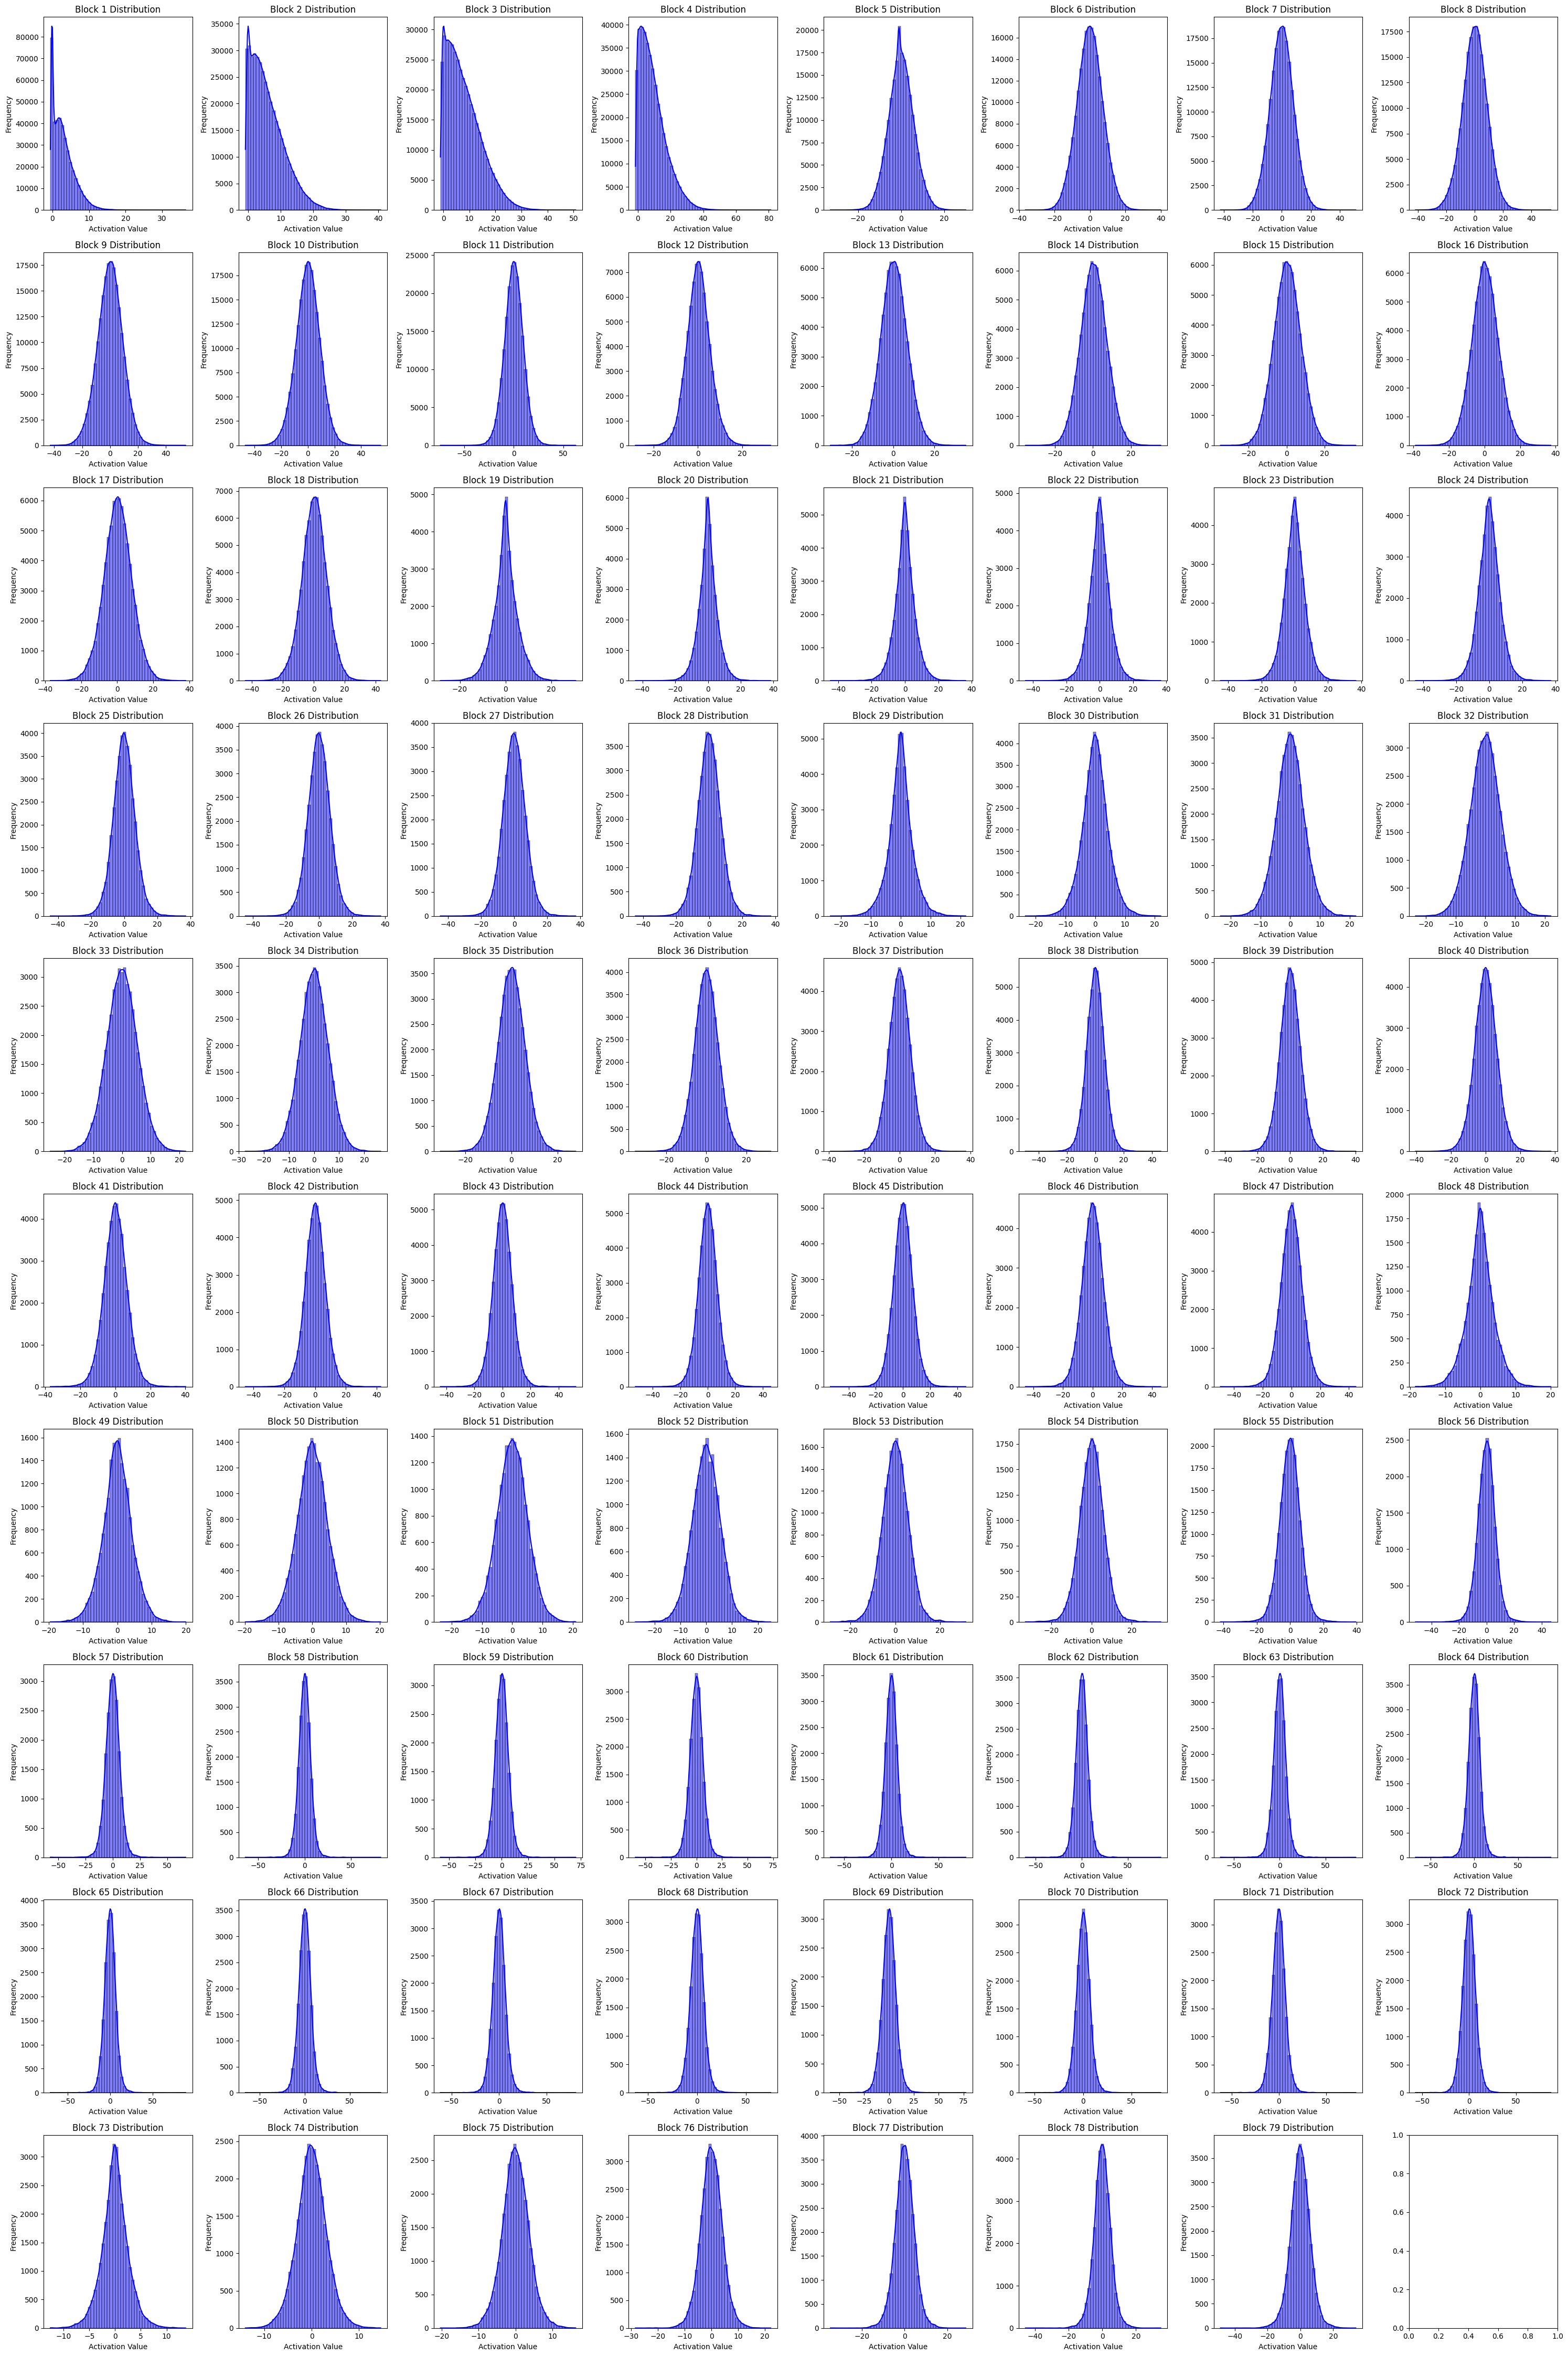

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models
import sys
import os

# 取得當前的工作目錄（例如你開 notebook 的位置）
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # 上一層
sys.path.append(parent_dir)

import model_efficient

# 如果想要使用預訓練權重，可以傳入 weights 參數
backbone = "EffV2_L"
model_map = {
    "EffV2_S": "tf_efficientnetv2_s_in21k",
    "EffV2_M": "tf_efficientnetv2_m_in21k",
    "EffV2_L": "tf_efficientnetv2_l_in21k",
    "EffV2_XL": "tf_efficientnetv2_xl_in21k",
}

base_model = model_efficient.EFB4DFR.load_from_checkpoint("/ssd5/Roy/BlockPruning/paper2025/celebdf_20250601_1532_21k_EffV2_L_21k_/checkpoints/celebdf_EffV2_L_epoch=1-train_acc=1.00-val_acc=1.00.ckpt")
base_model = base_model.base_model
base_model.to(device)

# 用來存儲各層輸出的列表
activations = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn(module, input, output):
    activations.append(output)

# 設置鉤子，將鉤子添加到每個 stage 和 unit
hooks = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 遍歷所有 stages 和 units，根據判斷註冊鉤子
for stage_idx, stage in enumerate(base_model.blocks):
    if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
        # print("stage:",stage)
        for unit_idx, unit in enumerate(stage):
            if has_children(unit):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
                print("unit:",unit)

print(len(hooks))

# 隨機生成輸入，形狀為 (1, 3, 224, 224)
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# 前向傳遞，這將觸發鉤子
base_model(input_tensor)

# 繪製每個 block 的數據分佈圖（直方圖）
fig, axes = plt.subplots(10, 8, figsize=(30, 45))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
for i in range(min(80, len(activations))):  # 確保最多繪製 32 張圖
    activation = activations[i].cpu().detach().numpy()  # 取得激活並轉換為 numpy 格式
    flattened_activation = activation.flatten()  # 展平為一維數據
    
    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation, kde=True, ax=axes[i], color='blue', bins=50)
    axes[i].set_title(f'Block {i+1} Distribution')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 釋放鉤子
for hook in hooks:
    hook.remove()



/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_l_in21k to current tf_efficientnetv2_l.in21k.
  model = create_fn(


79


/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


EffV2_L
self.new_channels: 0
79


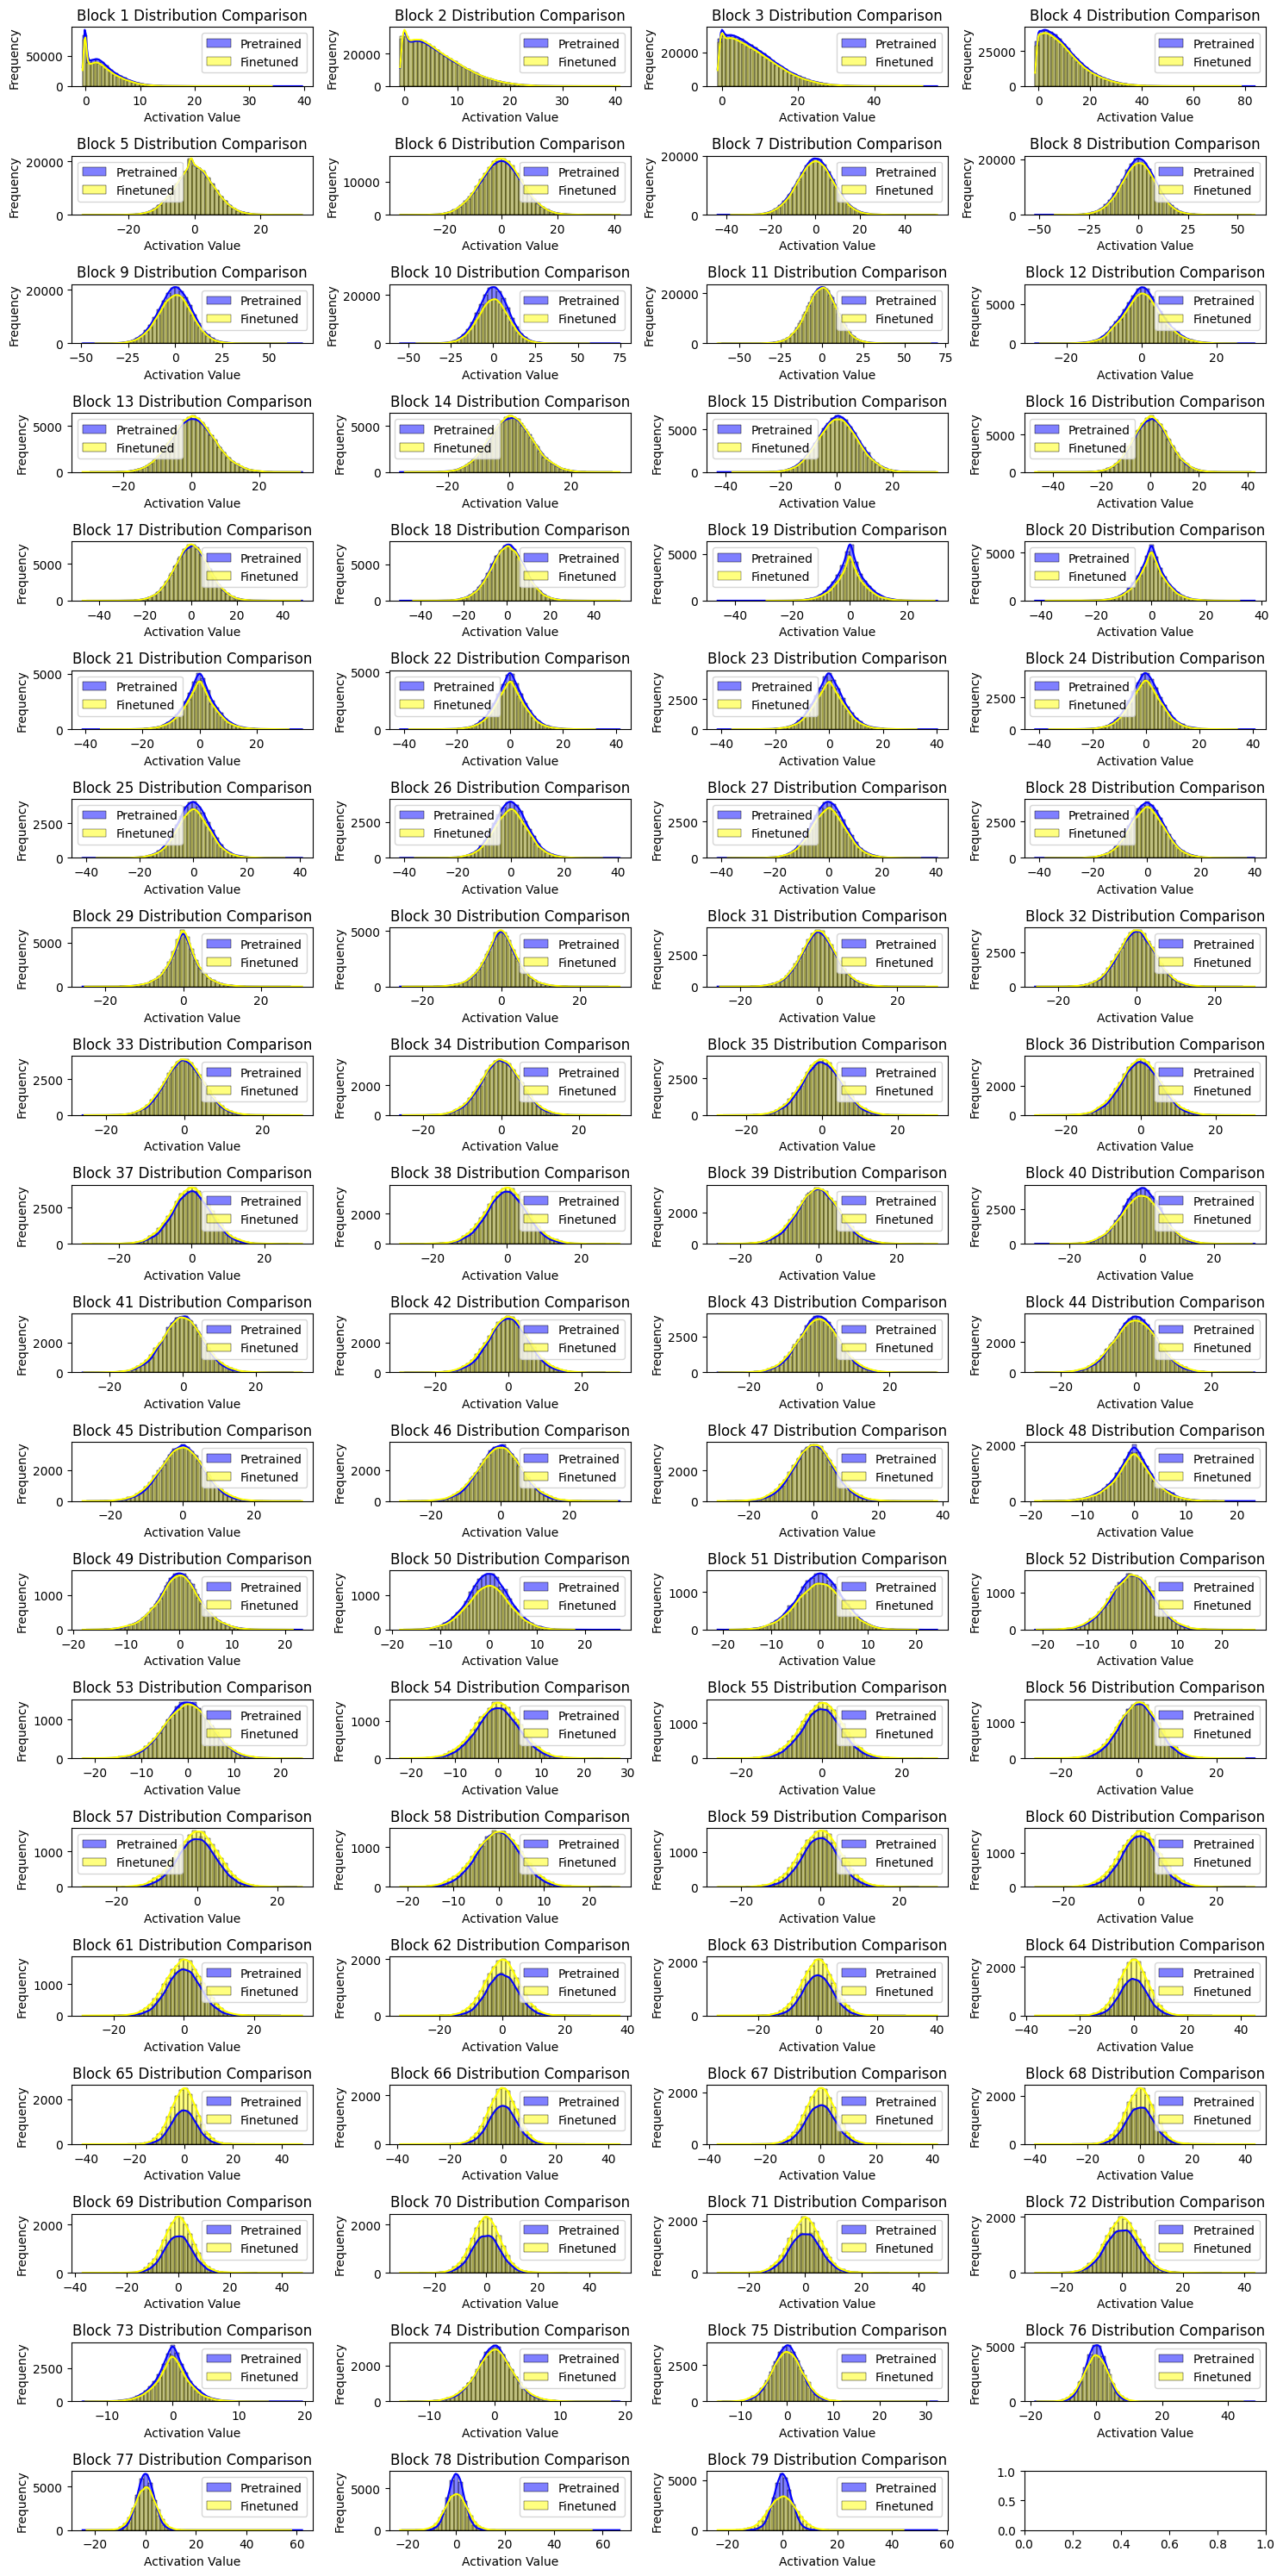

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models


# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []
hooks_finetuned = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.blocks):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 224, 224).to(device)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import timm
    backbone = "EffV2_L"
    model_map = {
        "EffV2_S": "tf_efficientnetv2_s_in21k",
        "EffV2_M": "tf_efficientnetv2_m_in21k",
        "EffV2_L": "tf_efficientnetv2_l_in21k",
        "EffV2_XL": "tf_efficientnetv2_xl_in21k",
    }
    model = timm.create_model(model_map[backbone], pretrained=True).to(device)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    import model_efficient
    model = model_efficient.EFB4DFR.load_from_checkpoint(finetuned_weights_path)
    model = model.base_model
    model.to(device)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/celebdf_20250601_1532_21k_EffV2_L_21k_/checkpoints/celebdf_EffV2_L_epoch=1-train_acc=1.00-val_acc=1.00.ckpt"

# 獲取自訓練權重的激活
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 繪製每個 block 的數據分佈圖（直方圖）並比較兩種權重
fig, axes = plt.subplots(20, 4, figsize=(15, 30))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
num_plots = min(80, len(activations_pretrained_copy), len(activations_finetuned))

for i in range(num_plots):  
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()  # 取得預訓練激活並轉換為 numpy 格式
    flattened_activation_pretrained = activation_pretrained.flatten()  # 展平為一維數據
    
    activation_finetuned = activations_finetuned[i].cpu().detach().numpy()  # 取得自訓練激活並轉換為 numpy 格式
    flattened_activation_finetuned = activation_finetuned.flatten()  # 展平為一維數據

    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation_pretrained, kde=True, ax=axes[i], color='blue', bins=50, label="Pretrained")
    sns.histplot(flattened_activation_finetuned, kde=True, ax=axes[i], color='yellow', bins=50, label="Finetuned")
    axes[i].set_title(f'Block {i+1} Distribution Comparison')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []
hooks_finetuned = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.blocks):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 224, 224).to(device)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import timm
    backbone = "EffV2_L"
    model_map = {
        "EffV2_S": "tf_efficientnetv2_s_in21k",
        "EffV2_M": "tf_efficientnetv2_m_in21k",
        "EffV2_L": "tf_efficientnetv2_l_in21k",
        "EffV2_XL": "tf_efficientnetv2_xl_in21k",
    }
    model = timm.create_model(model_map[backbone], pretrained=True).to(device)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    import model_efficient
    model = model_efficient.EFB4DFR.load_from_checkpoint(finetuned_weights_path)
    model = model.base_model
    model.to(device)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/celebdf_20250601_1532_21k_EffV2_L_21k_/checkpoints/celebdf_EffV2_L_epoch=1-train_acc=1.00-val_acc=1.00.ckpt"

# 獲取自訓練權重的激活
activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 統計信息
stats = []

num_plots = min(80, len(activations_pretrained_copy), len(activations_finetuned))

for i in range(num_plots):  
    # 取得預訓練激活並轉換為 numpy 格式
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()
    flattened_activation_pretrained = activation_pretrained.flatten()
    
    # 取得自訓練激活並轉換為 numpy 格式
    activation_finetuned = activations_finetuned[i].cpu().detach().numpy()
    flattened_activation_finetuned = activation_finetuned.flatten()

    # 計算均值和標準差
    mean_pretrained = np.mean(flattened_activation_pretrained)
    std_pretrained = np.std(flattened_activation_pretrained)
    
    mean_finetuned = np.mean(flattened_activation_finetuned)
    std_finetuned = np.std(flattened_activation_finetuned)

    # 獲取輸出形狀
    output_shape = activation_pretrained.shape

    # 存儲統計信息
    stats.append([i+1, output_shape, mean_pretrained, std_pretrained, mean_finetuned, std_finetuned])

# 創建 DataFrame 並顯示
columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained', 'mean of finetuned', 'std of finetuned']
df_stats = pd.DataFrame(stats, columns=columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Activation Statistics", dataframe=df_stats)  # 顯示數據表格

df_stats  # 顯示表格的前幾行以便查看



/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_l_in21k to current tf_efficientnetv2_l.in21k.
  model = create_fn(


79


/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


EffV2_L
self.new_channels: 0
79


,block_index,output shape,mean of pretrained,std of pretrained,mean of finetuned,std of finetuned
0,1,"(1, 32, 112, 112)",3.024250,2.982898,3.002099,2.956385
1,2,"(1, 32, 112, 112)",6.141836,5.198828,6.098021,5.159555
2,3,"(1, 32, 112, 112)",8.183009,6.722046,8.129051,6.681275
3,4,"(1, 32, 112, 112)",9.670020,8.109522,9.604114,8.073071
4,5,"(1, 64, 56, 56)",0.024841,5.932715,0.025506,5.886910
...,...,...,...,...,...,...
74,75,"(1, 640, 7, 7)",0.000133,3.110637,0.001988,3.393909
75,76,"(1, 640, 7, 7)",0.000146,3.299095,0.002506,3.785947
76,77,"(1, 640, 7, 7)",0.000175,3.447383,0.002939,4.189400
77,78,"(1, 640, 7, 7)",0.000228,3.436455,0.002921,4.572536


# MW Test & KS Test

In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.blocks):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import timm
    backbone = "EffV2_L"
    model_map = {
        "EffV2_S": "tf_efficientnetv2_s_in21k",
        "EffV2_M": "tf_efficientnetv2_m_in21k",
        "EffV2_L": "tf_efficientnetv2_l_in21k",
        "EffV2_XL": "tf_efficientnetv2_xl_in21k",
    }
    model = timm.create_model(model_map[backbone], pretrained=True).to(device)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    import sys
    import os

    # 取得當前的工作目錄（例如你開 notebook 的位置）
    current_dir = os.getcwd()
    parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # 上一層
    sys.path.append(parent_dir)

    import model_efficient
    model = model_efficient.EFB4DFR.load_from_checkpoint(finetuned_weights_path)
    model = model.base_model
    model.to(device)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑（根據你的路徑設定）
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/celebdf_20250601_1532_21k_EffV2_L_21k_/checkpoints/celebdf_EffV2_L_epoch=1-train_acc=1.00-val_acc=1.00.ckpt"

activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = min(len(activations_pretrained_copy), len(activations_finetuned))
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    # u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    
    # Finetuned 模型
    act_before_fine = activations_finetuned[i-1].numpy().flatten()
    act_after_fine  = activations_finetuned[i].numpy().flatten()

    act_before_fine = remove_outliers(act_before_fine)
    act_after_fine = remove_outliers(act_after_fine)

    # Mannwhitneyu
    u_stat_fine, p_val_fine = mannwhitneyu(act_before_fine, act_after_fine, alternative='two-sided')

    # KS
    # u_stat_fine, p_val_fine = ks_2samp(act_before_fine, act_after_fine)
    sig_fine = "*" if p_val_fine < 0.000641 else ""
    mean_fine = np.mean(act_after_fine)
    std_fine = np.std(act_after_fine)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, sig_pre, mean_fine, std_fine, sig_fine, p_val_fine])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained',
           'mean of finetuned', 'std of finetuned', 'sig of finetuned', 'p_val_fine']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))



79
EffV2_L
self.new_channels: 0
79


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,mean of finetuned,std of finetuned,sig of finetuned,p_val_fine
1,"torch.Size([1, 32, 112, 112])",5.883520,4.794210,*,5.730257,4.667574,*,0.000000
2,"torch.Size([1, 32, 112, 112])",7.902382,6.284039,*,7.693473,6.126332,*,0.000000
3,"torch.Size([1, 32, 112, 112])",9.123384,7.243344,*,8.875793,7.059954,*,0.000000
4,"torch.Size([1, 64, 56, 56])",-0.010329,5.642122,*,-0.004816,5.511631,*,0.000000
5,"torch.Size([1, 64, 56, 56])",-0.058037,7.224659,,-0.044487,7.032221,,0.085498
6,"torch.Size([1, 64, 56, 56])",-0.031820,7.996673,,-0.023664,7.769938,,0.147102
7,"torch.Size([1, 64, 56, 56])",0.023308,8.540411,*,0.027751,8.315272,,0.006916
8,"torch.Size([1, 64, 56, 56])",0.021803,8.735212,,0.034186,8.545701,,0.478810
9,"torch.Size([1, 64, 56, 56])",0.102753,8.692015,*,0.111443,8.538021,,0.014682
10,"torch.Size([1, 64, 56, 56])",0.132064,9.084756,,0.139179,8.883296,,0.520864


# 距離方法 EMD

In [3]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import wasserstein_distance  # 用於計算 EMD
import random

# 設定隨機種子，確保可重現性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(5)

# 設定 device 為 CPU
# device = torch.device("cpu")

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

# 判斷模組是否有子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空對應的激活紀錄
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()

    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location=device)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 註冊鉤子函數
    for stage_idx, stage in enumerate(model.blocks):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是 Sequential 模組
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    # 測試輸入，使用隨機 Tensor
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    model(input_tensor)

    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import timm
    backbone = "EffV2_L"
    model_map = {
        "EffV2_S": "tf_efficientnetv2_s_in21k",
        "EffV2_M": "tf_efficientnetv2_m_in21k",
        "EffV2_L": "tf_efficientnetv2_l_in21k",
        "EffV2_XL": "tf_efficientnetv2_xl_in21k",
    }
    model = timm.create_model(model_map[backbone], pretrained=True).to(device)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    import model_efficient
    model = model_efficient.EFB4DFR.load_from_checkpoint(finetuned_weights_path)
    model = model.base_model
    model.to(device)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250307_1619_21k_EffV2_L_21k_/checkpoints/ff++c23_EffV2_L_epoch=2-train_acc=1.00-val_acc=0.94.ckpt"

activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)

# 計算 EMD
def emd_distance(features1, features2):
    return wasserstein_distance(features1.flatten(), features2.flatten())

# 去除離群值
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

# 記錄結果
rows = []
n = min(len(activations_pretrained_copy), len(activations_finetuned))
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    emd_pre = emd_distance(act_before_pre, act_after_pre)
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    
    # Finetuned 模型
    act_before_fine = activations_finetuned[i-1].numpy().flatten()
    act_after_fine  = activations_finetuned[i].numpy().flatten()

    act_before_fine = remove_outliers(act_before_fine)
    act_after_fine = remove_outliers(act_after_fine)

    emd_fine = emd_distance(act_before_fine, act_after_fine)
    sig_fine = "*" if emd_fine>1.0 else ""
    mean_fine = np.mean(act_after_fine)
    std_fine = np.std(act_after_fine)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, emd_pre, mean_fine, std_fine, emd_fine, sig_fine])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'EMD of pretrained',
           'mean of finetuned', 'std of finetuned', 'EMD of finetuned', 'sig_fine']
df_stats = pd.DataFrame(rows, columns=columns)

# 顯示 DataFrame，隱藏 index
display(df_stats.style.hide(axis="index"))


ModuleNotFoundError: No module named 'model_efficient'

# 常態檢定

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda'

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

def hook_fn_finetuned(module, input, output):
    activations_finetuned.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.blocks):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import timm
    backbone = "EffV2_L"
    model_map = {
        "EffV2_S": "tf_efficientnetv2_s_in21k",
        "EffV2_M": "tf_efficientnetv2_m_in21k",
        "EffV2_L": "tf_efficientnetv2_l_in21k",
        "EffV2_XL": "tf_efficientnetv2_xl_in21k",
    }
    model = timm.create_model(model_map[backbone], pretrained=True).to(device)
    return model

# 自訓練權重的模型
def load_finetuned_model(finetuned_weights_path):
    import sys
    import os

    # 取得當前的工作目錄（例如你開 notebook 的位置）
    current_dir = os.getcwd()
    parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # 上一層
    sys.path.append(parent_dir)

    import model_efficient
    model = model_efficient.EFB4DFR.load_from_checkpoint(finetuned_weights_path)
    model = model.base_model
    model.to(device)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 自訓練權重的路徑（根據你的路徑設定）
finetuned_weights_path = "/ssd5/Roy/BlockPruning/paper2025/ff++c23_20250307_1619_21k_EffV2_L_21k_/checkpoints/ff++c23_EffV2_L_epoch=2-train_acc=1.00-val_acc=0.94.ckpt"

activations_finetuned.clear()
finetuned_model = load_finetuned_model(finetuned_weights_path)
get_activations_from_model(finetuned_model, hook_fn_finetuned, hooks_finetuned, finetuned_weights_path)


from scipy.stats import mannwhitneyu, ks_2samp, shapiro, kstest, norm

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = min(len(activations_pretrained_copy), len(activations_finetuned))
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mann-Whitney U test
    u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')
    sig_pre = "*" if p_val_pre < 0.05 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    
    # Finetuned 模型
    act_before_fine = activations_finetuned[i-1].numpy().flatten()
    act_after_fine  = activations_finetuned[i].numpy().flatten()

    act_before_fine = remove_outliers(act_before_fine)
    act_after_fine = remove_outliers(act_after_fine)

    # KS test (distribution change)
    u_stat_fine, p_val_fine = ks_2samp(act_before_fine, act_after_fine)
    sig_fine = "*" if p_val_fine < 0.00128 else ""
    mean_fine = np.mean(act_after_fine)
    std_fine = np.std(act_after_fine)

    # 常態檢定：Shapiro-Wilk 或 Kolmogorov–Smirnov
    if len(act_after_fine) <= 5000:
        try:
            stat_norm, p_val_norm = shapiro(act_after_fine)
            is_normal = "*" if p_val_norm > 0.05 else ""
        except Exception as e:
            p_val_norm = None
            is_normal = "err"
    else:
        # z-score 標準化再做 KS 檢定
        try:
            data_normed = (act_after_fine - np.mean(act_after_fine)) / np.std(act_after_fine)
            stat_norm, p_val_norm = kstest(data_normed, 'norm')
            is_normal = "*" if p_val_norm > 0.05 else ""
        except Exception as e:
            p_val_norm = None
            is_normal = "err"

    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([
        i, output_shape, 
        mean_pre, std_pre, sig_pre, 
        mean_fine, std_fine, sig_fine, 
        p_val_fine, p_val_norm, is_normal
    ])

# 建立 DataFrame
columns = [
    'block_index', 'output shape', 
    'mean of pretrained', 'std of pretrained', 'sig of pretrained',
    'mean of finetuned', 'std of finetuned', 'sig of finetuned',
    'p_val_fine', 'p_val_shapiro_or_ks', 'is_normal_finetuned'
]
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))




/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_l_in21k to current tf_efficientnetv2_l.in21k.
  model = create_fn(
/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


79


/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/hsujenlung/miniconda3/envs/Roy

EffV2_L


/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_l_in21k to current tf_efficientnetv2_l.in21k.
  model = create_fn(


self.new_channels: 0
79


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,mean of finetuned,std of finetuned,sig of finetuned,p_val_fine,p_val_shapiro_or_ks,is_normal_finetuned
1,"torch.Size([1, 32, 112, 112])",5.883520,4.794210,*,5.843147,4.761166,*,0.000000,0.000000,
2,"torch.Size([1, 32, 112, 112])",7.902382,6.284039,*,7.847976,6.245877,*,0.000000,0.000000,
3,"torch.Size([1, 32, 112, 112])",9.123384,7.243344,*,9.059883,7.208776,*,0.000000,0.000000,
4,"torch.Size([1, 64, 56, 56])",-0.010329,5.642122,*,-0.000494,5.615061,*,0.000000,0.000000,
5,"torch.Size([1, 64, 56, 56])",-0.058037,7.224659,,-0.052232,7.176805,*,0.000000,0.002176,
6,"torch.Size([1, 64, 56, 56])",-0.031820,7.996673,,-0.025573,7.941665,*,0.000000,0.001239,
7,"torch.Size([1, 64, 56, 56])",0.023308,8.540411,*,0.023260,8.497314,*,0.000000,0.000066,
8,"torch.Size([1, 64, 56, 56])",0.021803,8.735212,,0.028681,8.731952,*,0.000030,0.000069,
9,"torch.Size([1, 64, 56, 56])",0.102753,8.692015,*,0.102252,8.702728,,0.098262,0.000481,
10,"torch.Size([1, 64, 56, 56])",0.132064,9.084756,,0.132024,9.046968,*,0.000000,0.005663,
